## Import libraries## Import libraries

In [37]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
import os
import re
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

## Classification Audio files with SVM

In [38]:
def load_process(path):
    df = pd.read_csv(f'{path}/dem-info.csv')
    # fix 66* string value in Age column
    df['Age'] = df['Age'].apply(lambda x: x.replace('66*', '66'))
    df['Age'] = df['Age'].astype(int)

    # get_file_names
    for ext in ["CTD", "PFT", 'SFT']:
        df[f'{ext}_wav'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'__{ext}.wav'
        df[f'{ext}_txt'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'__{ext}.txt'

    return df

def load_process_cleaned(path):
    df = pd.read_csv(f'{path}/dem-info.csv')
    # fix 66* string value in Age column
    df['Age'] = df['Age'].apply(lambda x: x.replace('66*', '66'))
    df['Age'] = df['Age'].astype(int)

    # get_file_names
    for ext in ["CTD", "PFT", 'SFT']:
        df[f'{ext}_wav'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'_{ext}_clean.wav'
        df[f'{ext}_txt'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'_{ext}.txt'

    return df

process_path = './process/PROCESS-V1'
df = load_process(process_path)
df_clean = load_process_cleaned(process_path)

In [39]:
ctd_features = pd.read_csv("./process/features/process-ctd-w2v-feature.csv", header=None)
pft_features = pd.read_csv("./process/features/process-pft-w2v-feature.csv", header=None)
sft_features = pd.read_csv("./process/features/process-sft-w2v-feature.csv", header=None)
ctd_features_clean = pd.read_csv("./process/features/process-ctd-w2v-feature-clean.csv", header=None)
pft_features_clean = pd.read_csv("./process/features/process-pft-w2v-feature-clean.csv", header=None)
sft_features_clean = pd.read_csv("./process/features/process-sft-w2v-feature-clean.csv", header=None)

df['Converted-MMSE'] = df.groupby('Class')['Converted-MMSE'].transform(lambda x: x.fillna(x.mean()))
features = pd.concat([ctd_features_clean, pft_features_clean, sft_features_clean, df['Age']], axis=1, ignore_index=False)
X = features.to_numpy()
y_class, string_classes = pd.factorize(df['Class'])
y_reg = df["Converted-MMSE"]


In [40]:
svm_model = SVC(class_weight='balanced', kernel='linear', random_state=42, C=10, gamma=0.001)
rfe = RFECV(estimator=svm_model, step=1, cv=5, n_jobs=-1)
X_rfe = rfe.fit_transform(X, y_class)

cv_scores = cross_val_score(svm_model, X_rfe, y_class, cv=5, scoring='accuracy')
svm_pred = cross_val_predict(svm_model, X_rfe, y_class, cv=5)

print(f"Cross-Validation Accuracy (5-fold): {cv_scores}")
print(f"Durchschnittliche Genauigkeit: {cv_scores.mean()}")
print("Accuracy:", accuracy_score(y_class, svm_pred))
print("Classification Report:\n", classification_report(y_class, svm_pred))

Cross-Validation Accuracy (5-fold): [0.96875    0.875      0.70967742 0.87096774 0.83870968]
Durchschnittliche Genauigkeit: 0.8526209677419356
Accuracy: 0.8535031847133758
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84        59
           1       0.67      0.38      0.48        16
           2       0.92      0.93      0.92        82

    accuracy                           0.85       157
   macro avg       0.79      0.73      0.75       157
weighted avg       0.85      0.85      0.85       157



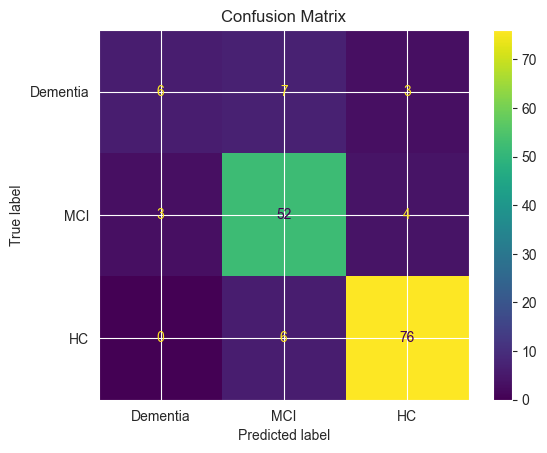

In [41]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

labels = ['Dementia', 'MCI', 'HC']
cm = confusion_matrix(y_class, svm_pred, labels=[1, 0, 2])
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dementia", "MCI", "HC"]).plot()
cmd.ax_.set_title('Confusion Matrix')
plt.show()



## Classification Text files with XGBoosting

In [42]:
# Helper function to extract data from text files
def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids

# Helper function to load labels
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df.set_index('Record-ID')[['Class', 'Age', 'Converted-MMSE']]  # Removed 'Gender'

# Load and combine data for CTD, PFT, and SFT
base_path = "./process/PROCESS-V1/"
file_patterns = {
    'CTD': r"Process-rec-\d+__CTD\.txt",
    'PFT': r"Process-rec-\d+__PFT\.txt",
    'SFT': r"Process-rec-\d+__SFT\.txt"
}
data_dict = {}
record_ids_dict = {}

for key, pattern in file_patterns.items():
    data, record_ids = load_data(pattern, base_path)
    data_dict[key] = data
    record_ids_dict[key] = record_ids

label_file = "./process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)

In [43]:
# Combine CTD, PFT, and SFT data
combined_data = []
for record_id in labels.index:
    if all(record_id in record_ids_dict[key] for key in file_patterns):
        ctd_text = data_dict['CTD'][record_ids_dict['CTD'].index(record_id)]
        pft_text = data_dict['PFT'][record_ids_dict['PFT'].index(record_id)]
        sft_text = data_dict['SFT'][record_ids_dict['SFT'].index(record_id)]
        row = labels.loc[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'CTD_Text': ctd_text,
            'PFT_Text': pft_text,
            'SFT_Text': sft_text,
            'Class': row['Class'],
            'Age': row['Age'],
            'Converted-MMSE': row['Converted-MMSE'],
        })

# Create DataFrame
df = pd.DataFrame(combined_data)

# Encode Class as labels (target)
df['Class'] = df['Class'].astype('category').cat.codes
class_weights = df['Class'].value_counts(normalize=True).to_dict()
for key in class_weights:
    class_weights[key] = 1.0 / class_weights[key]

df.dropna(inplace=True)

# Combine all text for text feature extraction
df['Combined_Text'] = df['CTD_Text'] + ' ' + df['PFT_Text'] + ' ' + df['SFT_Text']

# Prepare features and labels
X_combined_text = df['Combined_Text']
X_numeric = df[['Age', 'Converted-MMSE']]
y = df['Class']

In [44]:
# Extract text features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_text_features = tfidf_vectorizer.fit_transform(X_combined_text)

# Combine all features
X_combined = pd.concat([
    pd.DataFrame(X_text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out()),
    X_numeric.reset_index(drop=True)
], axis=1)

# Update and fit pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), X_numeric.columns.tolist()),
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Perform cross-validation and collect predictions
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 1, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_combined, y)

xgbmodel = grid_search.best_estimator_

C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best Score: 0.8659274193548387
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.83      0.62      0.71        16
          HC       0.91      0.91      0.91        82
         MCI       0.81      0.86      0.84        59

    accuracy                           0.87       157
   macro avg       0.85      0.80      0.82       157
weighted avg       0.87      0.87      0.86       157



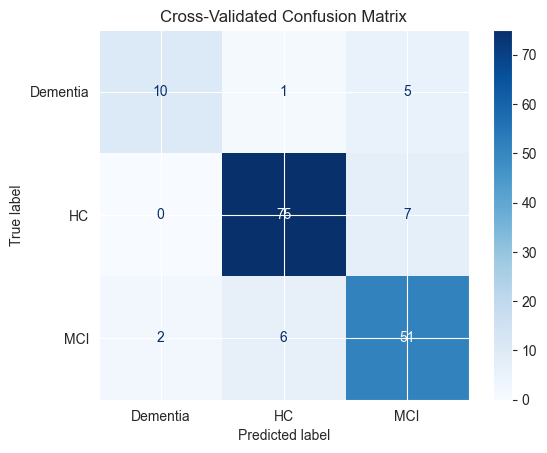

In [45]:
# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Cross-validated predictions
y_pred = cross_val_predict(grid_search.best_estimator_, X_combined, y, cv=5)

# Evaluate the model
print("Classification Report:")
print(classification_report(y, y_pred, target_names=labels['Class'].astype('category').cat.categories.tolist()))

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels['Class'].astype('category').cat.categories.tolist())
disp.plot(cmap=plt.cm.Blues)
plt.title("Cross-Validated Confusion Matrix")
plt.show()


## Combine SVM from Audio Files and XGBoost from Text Files

In [46]:
import pandas as pd
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler

# Audio-Features
ctd_features_clean = pd.read_csv("./process/features/process-ctd-w2v-feature-clean.csv", header=None)
pft_features_clean = pd.read_csv("./process/features/process-pft-w2v-feature-clean.csv", header=None)
sft_features_clean = pd.read_csv("./process/features/process-sft-w2v-feature-clean.csv", header=None)

# Combine audio features and convert to NumPy array
audio_features = pd.concat([ctd_features_clean, pft_features_clean, sft_features_clean], axis=1).to_numpy()

# Text-Features
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all text into a single column
df['Combined_Text'] = df['CTD_Text'] + ' ' + df['PFT_Text'] + ' ' + df['SFT_Text']

# Extract text features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
text_features = tfidf_vectorizer.fit_transform(df['Combined_Text'])

# Numeric Features
numeric_features = df[['Age', 'Converted-MMSE']]
scaler = MinMaxScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)  # Keep it as a NumPy array

# Combine all features
X_combined = hstack([
    text_features,  # Sparse matrix for text features
    audio_features,  # Numpy array for audio features
    numeric_features_scaled  # Scaled numeric features
])

# Target labels
y = df['Class']

print("Shape of combined features:", X_combined.shape)
print("Number of labels:", len(y))

Shape of combined features: (157, 5314)
Number of labels: 157


C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Beste Parameter: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8535031847133758
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.81      0.60        16
           1       0.99      0.85      0.92        82
           2       0.86      0.86      0.86        59

    accuracy                           0.85       157
   macro avg       0.78      0.84      0.79       157
weighted avg       0.89      0.85      0.86       157



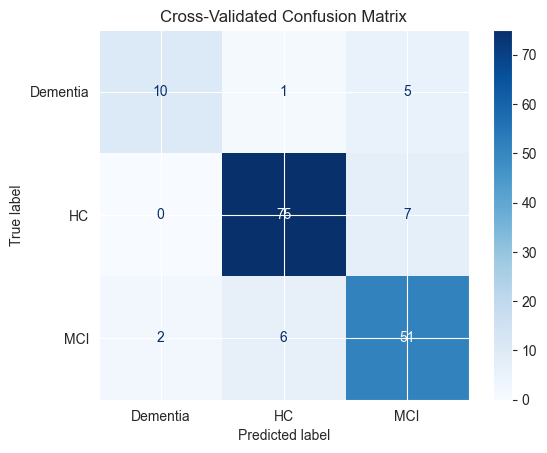

In [52]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Stellen Sie sicher, dass alle Arrays 2D sind
if svm_pred.ndim == 1:
    svm_pred = svm_pred.reshape(-1, 1)
if y_pred.ndim == 1:
    y_pred = y_pred.reshape(-1, 1)

# Kombinieren der Vorhersagen
meta_features = np.hstack([svm_pred, y_pred])

# Definition der Hyperparameter für GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearch mit 5-facher Cross-Validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1
)

# Ausführen der GridSearch
grid_search.fit(meta_features, y)

# Beste Parameter und Modell
best_rf_model = grid_search.best_estimator_
print("Beste Parameter:", grid_search.best_params_)

# Cross-Validated Predictions mit dem besten Modell
rf_pred = cross_val_predict(best_rf_model, meta_features, y, cv=5)

# Ergebnisse
print("Accuracy:", accuracy_score(y, rf_pred))
print("Classification Report:\n", classification_report(y, rf_pred))

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels['Class'].astype('category').cat.categories.tolist())
disp.plot(cmap=plt.cm.Blues)
plt.title("Cross-Validated Confusion Matrix")
plt.show()